In [1]:
import json
import tkp.db
import tkp.config
import logging
import csv
import time

import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp

from scipy.stats import norm
import datetime
import os
import struct
import glob
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky,  AltAz, EarthLocation
from astropy.io import fits
from astropy.wcs import WCS

from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
import matplotlib.dates as mdates


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
class TransitVis (object):
    fname       = None # Name of visibility binary file.
    hdr         = None # record header
    fvis        = None # File pointer to binary file
    nrec        = None # Total number of records in this file
    nbline      = None # Total number of baselines in this file
    tfilestart  = None # First timestamp in the file
    tfileend    = None # Last timestamp in the file

    # Information extracted from an individual header
    magic       = None
    trec        = None # Current records start time
    sub         = None # Subband number
    nant        = None # Total number of dual-pol antennas in the array.
    npol        = None # Number of polarizations in the observation
    pol2rec     = None # Number of polarizations per record.
    nchan       = None # Number of channels in this file
    norigchan   = None # Number of original channels before preprocessing.
    dt          = None # Integration time per record

    # Per polarization information
    flagged_channels= None # Independent per pol.
    flagged_dipoles = None # Independent per pol.
    ateamflux   = None # Independent per pol.
    weights     = None
    nweight     = None

    # Frequency associated with channel or averaged set of channels.
    freq        = None 

    recbuf      = None # Complete, single record read from file
    vis         = None # Usable visibility array per record (both pols)
    tstamps     = None # List containing timestamps of all records in a file.

    deblev      = None # Debug level for messages.
    missrec     = None # Number of records thrown due to mismatched times.

    # Function abstraction for raw and calibrated visibilities
    read_rec    = None # Function object, initialised to the right read func.
    read_hdr    = None # Function object, initialised to the right read func.
    parse_hdr   = None # Function object, initialised to the right parse func.

    def __init__ (self, fname, nant=None, sub=None, nchan=None, npol=None, 
                    arrayconfig=None):
        """ Initialization of internal state corresponding to a visibility dump.
            Since the correlator raw visibility magic number doesn't distinguish
            between AARTFAAC-6 or AARTFAAC-12, and has no subband information, 
            this can be supplied to the init routine.
        """
        # Check if fname is a valid file, and open
        self.fname = fname
        self.fvis = open (self.fname, 'r')
        self.hdr = self.fvis.read (LEN_HDR)
        self.npol = 2;

#         import pdb; pdb.set_trace();
        self.magic,self.tfilestart,trec = struct.unpack ("<Qdd", self.hdr[0:24])

#         if (self.magic == A06_HDR_MAGIC):
        self.nant     = 288
#             self.read_rec = self.read_cal
        self.parse_hdr= self.parse_cal_hdr
        self.read_hdr = self.read_cal_hdr
        self.nchan    = 1 # See record description in parse_cal_hdr
        self.nweight  = (6*7)/2 # Per station weights
        self.pol2rec  = 1



        # New format, stores only upper triangle float ACM
        self.nbline  = self.nant*(self.nant+1)/2
        # 8 due to float complex.
        self.payload = self.nbline * self.nchan * self.pol2rec * 8
        self.recsize = self.payload + LEN_HDR
        fsize = os.path.getsize(fname)

        # NOTE: We need to read 2 recs for getting both polarizations from .cal
        if self.magic == A12_HDR_MAGIC or self.magic == A06_HDR_MAGIC:
            self.nrec = fsize/(self.recsize*2)
        else:
            self.nrec = fsize/(self.recsize) # each record has both pols in .vis
            # First record has a corrupted timestamp in a .vis file
            self.fvis.seek (self.recsize, 0) 
            self.hdr = self.fvis.read (LEN_HDR)
            self.magic,self.tfilestart,trec = struct.unpack ("<Qdd", 
                                                        self.hdr[0:24])

        self.fvis.seek (0)
        self.dt = datetime.timedelta (seconds=(trec - self.tfilestart))# seconds
        self.tfilestart = datetime.datetime.utcfromtimestamp(self.tfilestart)
        
        # Find the last timestamp in a file.
        self.fvis.seek (0)
        self.fvis.seek ((self.nrec-1) * self.recsize)
        self.hdr = self.fvis.read (LEN_HDR)
        self.magic, self.tfileend, trec, self.sub, self.nant, pol, \
            self.norigchan, _, _, _, _, self.freq = self.parse_hdr (self.hdr)

        self.fvis.seek (0)


    def parse_cal_hdr(self, hdr):
        """
        Parse aartfaac header for calibrated data, independent per pol.
        Two pols are packed one after another, but with independent headers.
        struct output_header_t
        {
          uint64_t magic;                   ///< magic to determine header
          double start_time;                ///< start time (unix)
          double end_time;                  ///< end time (unix)
          int32_t subband;                  ///< lofar subband
          int32_t num_dipoles;              ///< number of dipoles (288 or 576)
          int32_t polarization;             ///< XX=0, YY=1
          int32_t num_channels;             ///< number of channels (<= 64)
          float ateam_flux[5];              ///< Ateam fluxes(CasA, CygA, Tau, Vir, Sun)
          std::bitset<5> ateam;             ///< Ateam active
          std::bitset<64> flagged_channels; ///< bitset of flagged channels (8 byte)
          std::bitset<576> flagged_dipoles; ///< bitset of flagged dipoles (72 byte)
          uint32_t weights[78];             ///< stationweights n*(n+1)/2, n in {6, 12}
          uint8_t pad[48];                  ///< 512 byte block
        };
        Record layout: The incoming channels in the raw visibilities from the
            correlator can be averaged in various combinations. The resulting
            averaged product gets its own record with an independent header.
            The record size for all records is the same, and corresponding data
            products (all records with the same channel integration, e.g.) will
            go into a single file. Other channel groups being averaged will go 
            into separate files.  
        """
        try:
            magic, t0, t1, sub, nant, pol, norigchan = struct.unpack("<Qddiiii",
                                                     hdr[0:40])
            ateamflux = struct.unpack("<fffff", hdr[40:60])
            ateam, flag_chans = struct.unpack("<QQ", hdr[60:76])
            flag_dips = struct.unpack ("<72b", hdr[76:148])
            weights = struct.unpack (("<%di" % self.nweight), 
                                    hdr[148:148+self.nweight*4]) # int weights
        except struct.error:
            print '### struct unpack error!'
            raise

        assert (magic == A06_HDR_MAGIC or magic == A12_HDR_MAGIC)
        # TODO: Examine the flagged channels to determine the actual frequency 
        # of the averaged channels. Currently return subband center.
        freq = sub * 195312.5 # Hz,
        
        return (magic, datetime.datetime.utcfromtimestamp(t0), datetime.datetime.utcfromtimestamp(t1), 
                sub, nant, pol, norigchan, ateamflux, flag_chans, flag_dips, weights, freq)

    # Return just the header, with metainformation extracted.
    # Faster than doing an actual read of the record payload.
    def read_cal_hdr (self, rec):
        
        assert (self.fvis)
        if (rec != None):
            raise NotImplemented

        # First pol.
        hdr = self.fvis.read (LEN_HDR)
        m, self.trec, t1, s, d, p, c, ateamflux, flag_chan, flag_dip, weights, \
                 freq = self.parse_hdr (hdr)
        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        self.fvis.seek (self.payload, 1)

        # Second polarization
        hdr = self.fvis.read (LEN_HDR)
        self.magic, trec, _, sub, self.nant, pol, \
            self.norigchan, ateamflux, flag_chan, flag_dip, weights, \
                    freq = self.parse_hdr (hdr)

        self.fvis.seek (self.payload, 1)
        # Check if both records correspond to the same trec
        # We can choose to keep only the single pol, or reject this record.
        if  (trec != self.trec):
            self.recbuf = 0
            self.fvis.seek (-self.recsize, 1) 
            print '## Mismatched times: pol %d tim: %s, pol %d tim: %s' \
                    % (p,self.trec, pol, trec)
            self.missrec = self.missrec + 1
            return -1

        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        return 1

In [3]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )
    
    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    print "Found", len(transients), "new sources"
    return transients

In [4]:
# import database username/password/etc.
import sys
sys.path.append('/home/kuiack')
from database_info import *
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING



In [5]:
CORR_HDR_MAGIC= 0x000000003B98F002 # Magic number in raw corr visibilities.
A06_HDR_MAGIC = 0x4141525446414143
A12_HDR_MAGIC = 0x4141525446414144
LEN_HDR       = 512

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

In [20]:
transients_query = """
    SELECT ex.f_int, ex.f_int_err, ex.f_peak, 
    ex.det_sigma, extract_type, 
    ex.ra, 
    ex.decl, 
    im.band,
    im.taustart_ts,
    im.freq_eff,
    im.id
    FROM extractedsource ex, image im 
    WHERE ex.id IN (select xtrsrc FROM assocxtrsource WHERE runcat = 464) 
    AND ex.image = im.id ;
    """


# dbname = "ASr_201810170300"
# runcat 1112
# 46 GP

# dbname = "ASr_20181101"
# runcat 117

# dbname = "ASf_20190101"
# runcat 1846

# dbname = "ASf_20181103"
# runcat 243

# dbname = "_201611140501"
# runcat 226

# dbname = "ASf_201804141730"
# runcat 464
# 63 GP

In [21]:
dbname = "ASf_201804141730"
dataset = 1

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

data = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

db._configured = False
del db, session

database name:  ASf_201804141730


In [10]:
db._configured = False
del db, session

NameError: name 'session' is not defined

In [7]:
# "/mnt/nex0/data/vis_archive/201901/300*20190101*"
# "/mnt/nex*/data/vis_archive/*201810*/300*201810170300*"
# "/mnt/nex*/data/vis_archive/*201811*/300*20181101*"
# "/mnt/nex*/data/vis_archive/*/300*20181103*"
# "/mnt/nex1/data/vis_archive/20161114/300-201611140501.cal"

f_list = sorted(glob.glob("/mnt/ais*/300-201909[0,1]*.cal"))
print f_list

['/mnt/ais003/300-201909010530.cal', '/mnt/ais003/300-201909010931.cal', '/mnt/ais003/300-201909011246.cal', '/mnt/ais003/300-201909011332.cal', '/mnt/ais003/300-201909011533.cal', '/mnt/ais003/300-201909011855.cal', '/mnt/ais003/300-201909020530.cal', '/mnt/ais003/300-201909020931.cal', '/mnt/ais003/300-201909021246.cal', '/mnt/ais003/300-201909021332.cal', '/mnt/ais003/300-201909021533.cal', '/mnt/ais003/300-201909021756.cal', '/mnt/ais003/300-201909030530.cal', '/mnt/ais003/300-201909030931.cal', '/mnt/ais003/300-201909031246.cal', '/mnt/ais003/300-201909031332.cal', '/mnt/ais003/300-201909031533.cal', '/mnt/ais003/300-201909031811.cal', '/mnt/ais003/300-201909040530.cal', '/mnt/ais003/300-201909040931.cal', '/mnt/ais003/300-201909041246.cal', '/mnt/ais003/300-201909041332.cal', '/mnt/ais003/300-201909041533.cal', '/mnt/ais003/300-201909050530.cal', '/mnt/ais003/300-201909050931.cal', '/mnt/ais003/300-201909051331.cal', '/mnt/ais003/300-201909051532.cal', '/mnt/ais003/300-2019090518

In [8]:

# f_list = glob.glob("/mnt/nex1/data/vis_archive/201804141730/300-201804141730.cal")

f_list = sorted(glob.glob("/mnt/ais*/300-201909[0,1]*.cal"))


tot_count = 0

obs_list = []
obs_count = []

starts = [] 
n_records = []
ends = [] 

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

position = SkyCoord(148.56*u.degree, 
                    7.66*u.degree)

for fname in f_list:
    vis = TransitVis (fname)
    print fname
    print "start:", vis.tfilestart 
#     print "end:", vis.tfileend
    print "end:", Time(vis.tfilestart) + vis.nrec*u.s
    print " "
    starts.append(vis.tfilestart)
    n_records.append(vis.nrec)
    ends.append(Time(vis.tfilestart) + vis.nrec*u.s)




for i in range(len(f_list)):

    obs_times = pd.date_range(starts[i], periods=n_records[i], freq='S', tz='utc')
    altaz = position.transform_to(AltAz(obstime=[j for j in obs_times], location=CS002))
    count = np.sum([(90. - altaz.alt.deg < 50.)])
    
    valid_time = obs_times[(90. - altaz.alt.deg < 50.)]
    print f_list[i]
    print "\t", count
    tot_count += count
    
    obs_list.append(f_list[i])
    obs_count.append(count)
    
    print str(i)+" / ", len(f_list)

# pd.DataFrame({"obs_list":obs_list,"obs_count":obs_count}).to_csv("/home/kuiack/PSR_observations.csv")

/mnt/ais003/300-201909010530.cal
start: 2019-09-01 05:32:00
end: 2019-09-01 09:26:42
 
/mnt/ais003/300-201909010931.cal
start: 2019-09-01 09:33:00
end: 2019-09-01 11:27:12
 
/mnt/ais003/300-201909011246.cal
start: 2019-09-01 12:48:00
end: 2019-09-01 13:29:42
 
/mnt/ais003/300-201909011332.cal
start: 2019-09-01 13:34:00
end: 2019-09-01 15:30:12
 
/mnt/ais003/300-201909011533.cal
start: 2019-09-01 15:35:00
end: 2019-09-01 17:28:13
 
/mnt/ais003/300-201909011855.cal
start: 2019-09-01 18:57:00
end: 2019-09-01 23:56:59
 
/mnt/ais003/300-201909020530.cal
start: 2019-09-02 05:32:00
end: 2019-09-02 09:26:46
 
/mnt/ais003/300-201909020931.cal
start: 2019-09-02 09:33:00
end: 2019-09-02 11:27:12
 
/mnt/ais003/300-201909021246.cal
start: 2019-09-02 12:48:00
end: 2019-09-02 13:29:40
 
/mnt/ais003/300-201909021332.cal
start: 2019-09-02 13:34:00
end: 2019-09-02 15:30:12
 
/mnt/ais003/300-201909021533.cal
start: 2019-09-02 15:35:00
end: 2019-09-02 17:28:13
 
/mnt/ais003/300-201909021756.cal
start: 201

A coordinate or time-related calculation might be compromised or fail because the dates are not covered by the available IERS file.  See the "IERS data access" section of the astropy documentation for additional information on working offline. [astropy.utils.iers.iers]


/mnt/ais003/300-201909010530.cal
	1410
0 /  91
/mnt/ais003/300-201909010931.cal
	6852
1 /  91
/mnt/ais003/300-201909011246.cal
	0
2 /  91
/mnt/ais003/300-201909011332.cal
	0
3 /  91
/mnt/ais003/300-201909011533.cal
	0
4 /  91
/mnt/ais003/300-201909011855.cal
	0
5 /  91
/mnt/ais003/300-201909020530.cal
	1650
6 /  91
/mnt/ais003/300-201909020931.cal
	6852
7 /  91
/mnt/ais003/300-201909021246.cal
	0
8 /  91
/mnt/ais003/300-201909021332.cal
	0
9 /  91
/mnt/ais003/300-201909021533.cal
	0
10 /  91
/mnt/ais003/300-201909021756.cal
	0
11 /  91
/mnt/ais003/300-201909030530.cal
	1971
12 /  91
/mnt/ais003/300-201909030931.cal
	6853
13 /  91
/mnt/ais003/300-201909031246.cal
	0
14 /  91
/mnt/ais003/300-201909031332.cal
	0
15 /  91
/mnt/ais003/300-201909031533.cal
	0
16 /  91
/mnt/ais003/300-201909031811.cal
	0
17 /  91
/mnt/ais003/300-201909040530.cal
	2120
18 /  91
/mnt/ais003/300-201909040931.cal
	6852
19 /  91
/mnt/ais003/300-201909041246.cal
	0
20 /  91
/mnt/ais003/300-201909041332.cal
	0
21 / 

In [9]:
print tot_count


94947


In [13]:
print min(valid_time)
print max(valid_time)

2018-04-14 18:12:38.502610+00:00
2018-04-14 21:39:18.502610+00:00


In [191]:

x = (np.sort(data.f_int.values))
y = np.array((np.array(range(len(data.f_int.values))[::-1])))


TypeError: Improper input: N=2 must not exceed M=0

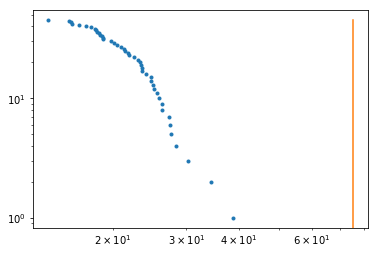

In [12]:
def powlaw(x,a,b):
    return a*x**b

flux_limit = 75

x = (np.sort(data.f_int.values))
y = np.array((np.array(range(len(data.f_int.values))[::-1])))



plt.plot(x, y, ".")
plt.xscale("log")
plt.yscale("log")

plt.plot([flux_limit, flux_limit], [np.min(y), np.max(y)])

fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)], maxfev=2000)


plt.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))


plt.legend()


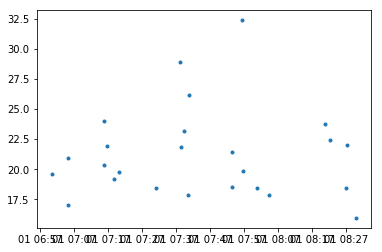

In [74]:
plt.plot(data.taustart_ts,data.f_int,".")
# plt.ylim([0,300])

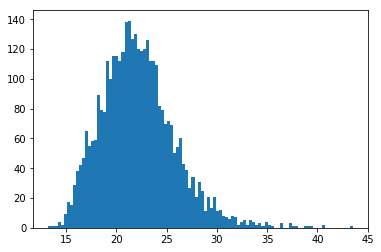

In [68]:
mm = plt.hist(data.f_int, bins=100)

In [58]:
data

,band,decl,det_sigma,extract_type,f_int,f_int_err,f_peak,freq_eff,ra,taustart_ts
0,24,29.497397,5.332567,0,4.026493e+09,1.355298e+09,3.874431e+09,58300780.0,267.069291,2018-11-01 12:04:07
1,24,29.497397,2.258893,1,-5.363231e+00,7.909129e+00,-1.475380e+00,58300780.0,267.069291,2018-11-01 12:04:08
2,23,29.497397,2.361956,1,3.365403e-01,8.328322e+00,-6.836345e+01,61816408.0,267.069291,2018-11-01 12:04:08
3,24,29.497397,1.809403,1,-1.097402e+01,7.910555e+00,-9.073259e+00,58333332.0,267.069291,2018-11-01 12:04:09
4,23,29.497397,2.422355,1,-3.971192e+00,8.619650e+00,2.265253e+00,61816408.0,267.069291,2018-11-01 12:04:09
5,24,29.497397,2.047748,1,-1.054787e+01,7.991643e+00,-8.529568e+00,58300780.0,267.069291,2018-11-01 12:04:10
6,23,29.497397,2.202130,1,-6.168725e-01,8.195090e+00,3.567345e+01,61816408.0,267.069291,2018-11-01 12:04:10
7,24,29.497397,2.208934,1,-7.639100e+00,7.043676e+00,-5.474213e+00,58370536.0,267.069291,2018-11-01 12:04:11
8,23,29.497397,2.241475,1,-1.406820e+00,8.362960e+00,1.516462e+01,61816408.0,267.069291,2018-11-01 12:04:11
9,24,29.497397,2.086352,1,-8.097190e+00,7.852002e+00,-5.559110e+00,58333332.0,267.069291,2018-11-01 12:04:12


In [126]:
x1 = x 
y1 = y

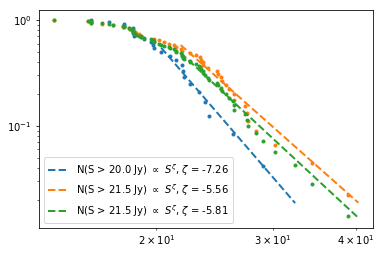

In [148]:
plt.plot(x, y/float(np.max(y)), ".",c="C0")

flux_limit = 20
fit, cov = curve_fit(powlaw, x[(x > flux_limit)], y[(x > flux_limit)], maxfev=2000)


plt.plot(x[(x > flux_limit)],
         powlaw(x[(x > flux_limit)],fit[0],fit[1])/float(np.max(y)), "--",c="C0",lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))


flux_limit = 21.5
plt.plot(x1, y1/float(np.max(y1)), ".",c="C1")
fit, cov = curve_fit(powlaw, x1[(x1 > flux_limit)], y1[(x1 > flux_limit)], maxfev=2000)

plt.plot(x1[(x1 > flux_limit)],
         powlaw(x1[(x1 > flux_limit)],fit[0],fit[1])/float(np.max(y1)), "--", c="C1",lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))



z = (np.sort(np.concatenate([x,x1])))
yz = np.array((np.array(range(len(z))[::-1])))

plt.plot(z, yz/float(np.max(yz)), ".", c="C2")

flux_limit = 21.5

fit, cov = curve_fit(powlaw, z[(z > flux_limit)], yz[(z > flux_limit)]/float(np.max(yz)), maxfev=2000)
plt.plot(z[(z > flux_limit)],
         powlaw(z[(z > flux_limit)],fit[0],fit[1]), "--", c="C2",lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))

plt.xscale("log")
plt.yscale("log")
plt.legend()

## Flux calibrate Giant Pulses.

In [23]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes

In [24]:
ref_cat = pd.read_csv("~/AARTFAAC_catalogue.csv")

# import database username/password/etc.
import sys
sys.path.append('/home/kuiack')
from database_info import *
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING




In [25]:
t1 = time.time()

dbname = "ASf_201804141730"
dataset = 1

flux_compare = []
flux_correct = []


for i in range(len(data)):
#     print data.iloc[i].id

    db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()

#     for j in range(len(GP_df)):


    transients_query = """SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl 
    FROM extractedsource ex 
    WHERE ex.image = (SELECT id FROM image 
    WHERE taustart_ts = '{}' AND band = {});""".format(data.iloc[i].taustart_ts,
                                                       data.iloc[i].band)


    image_pyse = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))


    slope_cor, intercept_cor, ref_match, image_match, index_match = compare_flux(image_pyse,
                                       ref_cat["ra"],
                                       ref_cat["decl"],
                                       ref_cat["f_int"],
                                       ref_cat["f_int_err"])


    flux_compare.append([np.array(ref_match),
                         (np.array(image_match) - intercept_cor)/slope_cor,
                        np.array(np.ravel(index_match))])
    
    flux_correct.append([i, slope_cor, intercept_cor])
    
        
    db._configured = False
    del db, session

print "processing time:", time.time() -t1

processing time: 29.4627640247


In [26]:
test = pd.DataFrame([])

for i in range(len(flux_compare)):

    if len(test) == 0:
        test = pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])

    else:
        test = pd.concat([test,
               pd.DataFrame({"reference":flux_compare[i][0],
                             "image":flux_compare[i][1]},
                            index=flux_compare[i][2])])
        
group_test = test.groupby(test.index).median()

/afhome/kuiack/newtrap/lib/python2.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


mu: 1.00486757057 sigma: 0.323784606482


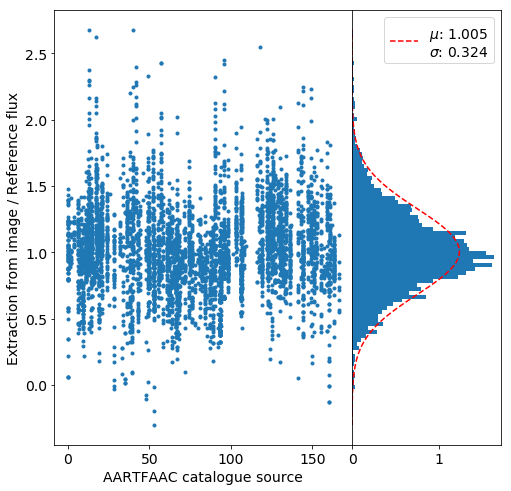

In [27]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(8,8))
gs1 = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
gs1.update(wspace=0.0, hspace=0.0)



# plt.subplot(121)
plt.subplot(gs1[0])
plt.plot( test.image/test.reference, ".", label="Individual Extraction")
plt.ylabel("Extraction from image / Reference flux")
plt.xlabel("AARTFAAC catalogue source")
(mu, sigma) = norm.fit(test.image/test.reference)
#     n, bins, patches   =  plt.hist(source_df["f_int"].values[hist_index],
#                                    bins=100,normed=1, orientation='horizontal',facecolor="#1f77b4")


# plt.subplot(122)
plt.subplot(gs1[1])
n, bins, patches   =  plt.hist(test.image/test.reference, bins=100, normed=1, orientation="horizontal")
y = mlab.normpdf( bins, mu, sigma)
plt.plot(y,bins,"--", c="red", label=r"$\mu$"": {}\n"r"$\sigma$"": {}".format(round(mu,3),round(sigma,3)))
plt.legend()
plt.yticks([])


# plt.xlim([-0.5,4])
print "mu:", mu,"sigma:", sigma
# plt.tight_layout()

In [223]:
data

,band,decl,det_sigma,extract_type,f_int,f_int_err,f_peak,freq_eff,id,ra,taustart_ts
0,24,7.568437,5.655872,0,19.631367,6.155441,18.988018,58300780.0,22,148.603514,2018-11-01 07:00:23
1,24,7.676754,5.618327,0,20.950787,6.767037,20.222210,58320312.0,576,148.563203,2018-11-01 07:05:02
2,23,7.713931,5.463313,0,16.984132,5.658677,16.355691,61816408.0,577,148.556288,2018-11-01 07:05:02
3,23,7.705000,5.868326,0,24.025641,7.230649,23.300273,61816408.0,1839,148.565748,2018-11-01 07:15:37
4,23,7.583609,5.143355,0,20.343713,6.952514,19.551701,61816408.0,1863,148.597346,2018-11-01 07:15:49
5,23,7.584792,5.513847,0,21.918696,7.092167,21.153766,61816408.0,1959,148.575310,2018-11-01 07:16:37
6,23,7.520377,5.029054,0,19.193232,6.799637,18.390257,61816408.0,2221,148.591864,2018-11-01 07:18:49
7,23,7.486114,5.177148,0,19.770006,6.909890,18.964972,61816408.0,2395,148.561606,2018-11-01 07:20:17
8,23,7.634721,5.391473,0,18.420988,6.230489,17.718546,61816408.0,3693,148.583064,2018-11-01 07:31:10
9,23,7.713568,8.586098,0,28.947275,6.433674,28.470636,61816408.0,4511,148.573164,2018-11-01 07:38:02


In [224]:
flux_correct = np.array(flux_correct)
(data.f_int - flux_correct[:,2])/flux_correct[:,1]

0     50.499616
1     52.984477
2     46.759655
3     63.259491
4     53.816070
5     58.928898
6     51.147265
7     53.551255
8     52.298107
9     77.608969
10    63.136353
11    63.534710
12    49.770819
13    70.111726
14    46.891670
15    59.879820
16    87.943014
17    57.427379
18    52.378457
19    51.115091
20    68.659789
21    68.068180
22    55.437004
23    68.504048
24    46.491840
Name: f_int, dtype: float64

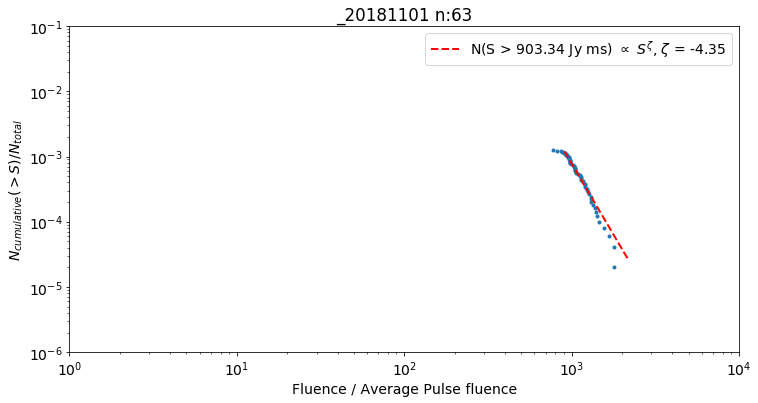

In [28]:
def powlaw(x,a,b):
    return a*x**b

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14
       }


matplotlib.rc('font', **font)


flux_correct = np.array(flux_correct)
x_F = ((np.sort((data.f_int - flux_correct[:,2])/flux_correct[:,1]))*1000.)/55.35
y_F = np.array((np.array(range(len(x_F))[::-1])))/(4.*sum(obs_count))


flux_limit = 50000/55.35

plt.figure(figsize=(12,6))
plt.plot(x_F, y_F, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("_20181101 n:{}".format(len(x_F)))
# plt.plot([flux_limit, flux_limit], [np.min(y_F), np.max(y_F)])

fit, cov = curve_fit(powlaw, x_F[(x_F > flux_limit)], y_F[(x_F > flux_limit)], maxfev=2000)


plt.plot(x_F[(x_F > flux_limit)],
         powlaw(x_F[(x_F > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))
# plt.plot(_20181101["x"],_20181101["y"], ".")

plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")

plt.xlim(1,10000)
plt.ylim(1e-6,1e-1)
plt.legend()

In [29]:
np.savez("/home/kuiack/ASf_201804141730.npz", x=x_F, y=y_F, obs_count=sum(obs_count))

In [72]:
_20181101 = np.load("/home/kuiack/_20181101.npz")

In [85]:
# np.savez("/home/kuiack/_201810170300.npz", x=x_F, y=y_F, obs_count=obs_count)
# np.savez("/home/kuiack/ASf_20190101.npz", x=x_F, y=y_F, obs_count=obs_count)

In [121]:
obs_count

[1256, 0, 0]

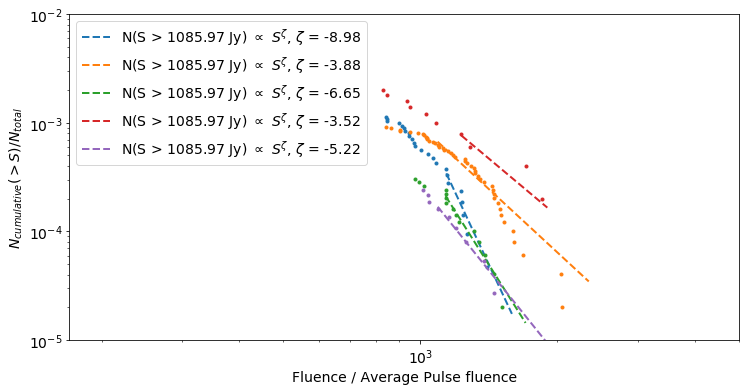

In [30]:
_20181101 = np.load("/home/kuiack/_20181101.npz")
_201810170300 = np.load("/home/kuiack/_201810170300.npz")
ASf_20190101 = np.load("/home/kuiack/ASf_20190101.npz")
ASf_20181103 = np.load("/home/kuiack/ASf_20181103.npz")
_201611140501 = np.load("/home/kuiack/_201611140501.npz")

plt.figure(figsize=(12,6))

plt.plot(_20181101["x"],
         _20181101["y"], ".", c="C0")

flux_limit = 60000/55.25
fit, cov = curve_fit(powlaw, _20181101["x"][(_20181101["x"]> flux_limit)], 
                     _20181101["y"][(_20181101["x"] > flux_limit)], maxfev=2000)

plt.plot(_20181101["x"][(_20181101["x"]  > flux_limit)],
         powlaw(_20181101["x"][(_20181101["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C0")



plt.plot(_201810170300["x"],
         _201810170300["y"], ".", c="C1")

flux_limit = 60000/55.25

fit, cov = curve_fit(powlaw, _201810170300["x"][(_201810170300["x"] > flux_limit)], 
                     _201810170300["y"][(_201810170300["x"] > flux_limit)], maxfev=2000)

plt.plot(_201810170300["x"][(_201810170300["x"]  > flux_limit)],
         powlaw(_201810170300["x"][(_201810170300["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C1")


plt.plot(ASf_20190101["x"],
         ASf_20190101["y"], ".", c="C2")

flux_limit = 60000/55.25

fit, cov = curve_fit(powlaw, ASf_20190101["x"][(ASf_20190101["x"] > flux_limit)], 
                     ASf_20190101["y"][(ASf_20190101["x"] > flux_limit)], maxfev=2000)

plt.plot(ASf_20190101["x"][(ASf_20190101["x"]  > flux_limit)],
         powlaw(ASf_20190101["x"][(ASf_20190101["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C2")

plt.plot(ASf_20181103["x"],
         ASf_20181103["y"], ".", c="C3")

flux_limit = 60000/55.25

fit, cov = curve_fit(powlaw, ASf_20181103["x"][(ASf_20181103["x"] > flux_limit)], 
                     ASf_20181103["y"][(ASf_20181103["x"] > flux_limit)], maxfev=2000)

plt.plot(ASf_20181103["x"][(ASf_20181103["x"]  > flux_limit)],
         powlaw(ASf_20181103["x"][(ASf_20181103["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C3")


plt.plot(_201611140501["x"],
         _201611140501["y"], ".", c="C4")

flux_limit = 60000/55.25

fit, cov = curve_fit(powlaw, _201611140501["x"][(_201611140501["x"] > flux_limit)], 
                     _201611140501["y"][(_201611140501["x"] > flux_limit)], maxfev=2000)

plt.plot(_201611140501["x"][(_201611140501["x"]  > flux_limit)],
         powlaw(_201611140501["x"][(_201611140501["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C4")


plt.xscale("log")
plt.yscale("log")

plt.xlim(170,5000)
plt.ylim(1e-5,1e-2)

plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")
plt.legend()

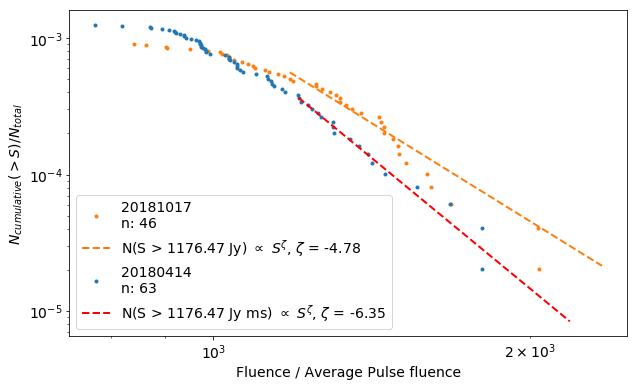

In [42]:
plt.figure(figsize=(10,6))

plt.plot(_201810170300["x"],
         _201810170300["y"], ".", c="C1", label="20181017\n""n: {}".format(len(_201810170300["x"])))

flux_limit = 65000/55.25

fit, cov = curve_fit(powlaw, _201810170300["x"][(_201810170300["x"] > flux_limit)], 
                     _201810170300["y"][(_201810170300["x"] > flux_limit)], maxfev=2000)

plt.plot(_201810170300["x"][(_201810170300["x"]  > flux_limit)],
         powlaw(_201810170300["x"][(_201810170300["x"]  > flux_limit)],fit[0],fit[1]), "--", lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit), c="C1")





plt.plot(x_F, y_F, ".", label="20180414\n""n: {}".format(len(x_F)))
plt.xscale("log")
plt.yscale("log")
# plt.title("_20181101 n:{}".format(len(x_F)))
# plt.plot([flux_limit, flux_limit], [np.min(y_F), np.max(y_F)])

fit, cov = curve_fit(powlaw, x_F[(x_F > flux_limit)], y_F[(x_F > flux_limit)], maxfev=2000)


plt.plot(x_F[(x_F > flux_limit)],
         powlaw(x_F[(x_F > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))
# plt.plot(_20181101["x"],_20181101["y"], ".")

plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")

# plt.xlim(1,10000)
# plt.ylim(1e-6,1e-1)
plt.legend()

In [45]:
new_x = np.concatenate((x_F,_20181101["x"],_201810170300["x"],ASf_20190101["x"],ASf_20181103["x"],_201611140501["x"]))
new_y = np.concatenate((y_F, _20181101["y"],_201810170300["y"],ASf_20190101["y"],ASf_20181103["y"],_201611140501["y"]))

Text(0.5,0,'Fluence / Average Pulse fluence')

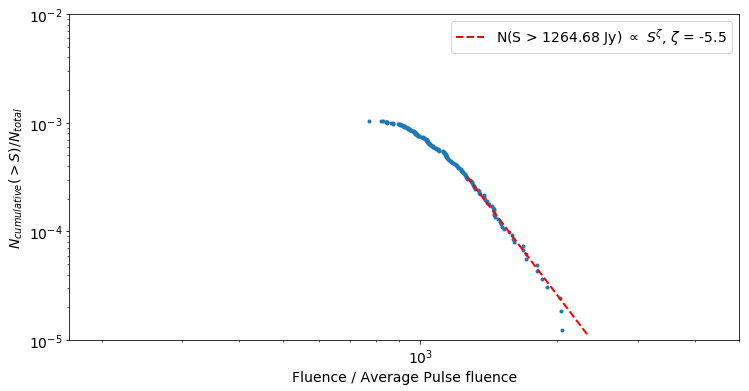

In [51]:
flux_limit = 70000/55.35


index = np.argsort(new_x)
# new_xf = new_x[index]
new_xf = np.sort(new_x)
# new_yf = new_y[index]
new_yf = np.array((np.array(range(len(new_x))[::-1])))/(4.*np.sum([_20181101["obs_count"],_201810170300["obs_count"],ASf_20190101["obs_count"],ASf_20181103["obs_count"],_201611140501["obs_count"]])

)

plt.figure(figsize=(12,6))

plt.plot(new_xf, new_yf , ".")

# plt.plot([flux_limit, flux_limit], [np.min(new_yf ), np.max(new_yf )])

fit, cov = curve_fit(powlaw, new_xf [(new_xf  > flux_limit)], new_yf [(new_xf  > flux_limit)], maxfev=2000)


plt.plot(new_xf [(new_xf  > flux_limit)],
         powlaw(new_xf [(new_xf  > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
         label="N(S > {} Jy) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
                                                        round(fit[1],2), 
                                                        flux_limit))


# flux_limit = 60000/55.35

# plt.plot(x_F, y_F, ".")
# # plt.xscale("log")
# # plt.yscale("log")
# # plt.title("_20181101 n:{}".format(len(x_F)))
# # plt.plot([flux_limit, flux_limit], [np.min(y_F), np.max(y_F)])

# fit, cov = curve_fit(powlaw, x_F[(x_F > flux_limit)], y_F[(x_F > flux_limit)], maxfev=2000)


# plt.plot(x_F[(x_F > flux_limit)],
#          powlaw(x_F[(x_F > flux_limit)],fit[0],fit[1]), "--", c="r",lw =2, 
#          label="N(S > {} Jy ms) "r"$\propto$"" "r"$S^\zeta$"", "r"$\zeta$"" = {}".format( round(flux_limit,2), 
#                                                         round(fit[1],2), 
#                                                         flux_limit))


plt.legend()

plt.xscale("log")
plt.yscale("log")

plt.xlim(170,5000)
plt.ylim(1e-5,1e-2)

plt.ylabel(r"$N_{cumulative}( > S)/N_{total}$")
plt.xlabel("Fluence / Average Pulse fluence")

In [178]:
np.sum([_20181101["obs_count"],_201810170300["obs_count"],ASf_20190101["obs_count"],ASf_20181103["obs_count"],_201611140501["obs_count"]])




40676

171